In [4]:
import numpy as np
import tensorflow.keras as k
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3

In [26]:
conn = sqlite3.connect('../../data/baza_projekt.db')
# counties = pd.read_sql_query('SELECT * FROM unemployment', conn).iloc[:, :3]
counties = pd.read_sql_query(""" 
select e.[FIPS code],
       e.State,
       e.[Area name],
       "Percent of adults completing some college or associate's degree, 2017-21"  + "Percent of adults with a bachelor's degree or higher, 2017-21" as "Higher Education",
       "2016 HPI Change" as HPI,
       "2016 Population (persons) 1/" as Income,
       "Unemployment_rate_2016" as Unemployment,
       "Poor physical health days raw value 2016" as "Poor physical health days",
       "Poor mental health days raw value 2016" as "Poor mental health days",
       "Violent crime raw value 2016" as "Violent crime",
       "Severe housing problems raw value 2016" as "Severe housing problems",
       "Income inequality raw value 2016" as "Income inequality",
       "Access to exercise opportunities raw value 2016" as "Access to exercise opportunities"
from education as e
    inner join hpi as h on h.[FIPS code] = e.[FIPS code]
    inner join income as i on i.[FIPS code] = e.[FIPS code]
    inner join unemployment as u on u.[FIPS code] = e.[FIPS code]
    inner join health as he on he.[FIPS code] = e.[FIPS code]
    """,
    conn
    )


counties['FIPS code'] = counties['FIPS code'].astype(str).apply(lambda x: '0'+x if len(x)==4 else x)
counties = counties.fillna(value=0)
conn.close()
counties.head()

,FIPS code,State,Area name,Higher Education,HPI,Income,Unemployment,Poor physical health days,Poor mental health days,Violent crime,Severe housing problems,Income inequality,Access to exercise opportunities
0,01001,Alabama,Autauga County,56.825870,2.64,56954,5.1,4.4,4.3,253.644617,0.136193,4.303481,0.708215
1,01003,Alabama,Baldwin County,63.638665,5.20,210004,5.4,4.1,4.2,220.665106,0.147079,4.494800,0.721685
2,01005,Alabama,Barbour County,38.994165,-0.68,26217,8.4,4.9,4.7,146.888576,0.175597,5.285567,0.452671
3,01007,Alabama,Bibb County,36.619543,3.95,22654,6.5,4.8,4.6,235.952110,0.129993,4.251361,0.328388
4,01009,Alabama,Blount County,48.524639,1.66,58238,5.4,4.6,4.5,219.034344,0.123395,4.124186,0.255085


### Trening modeli dla hrabstw

In [27]:
class County:
    def __init__(self, name, fips_code, feature_vector=None) -> None:
        self.name = name
        self.fips_code = fips_code
        if feature_vector is None:
            self.feature_vector = np.random.uniform(size=(5,))
            self.f1 = self.feature_vector[0]
            self.f2 = self.feature_vector[1]
            self.f3 = self.feature_vector[2]
            self.f4 = self.feature_vector[3]
            self.f5 = self.feature_vector[4]
        else:
            self.feature_vector = feature_vector
        self.virtual_county = self._get_vitrtual_county()
        self.embeding_model = None
        self.distribution_parametrers = dict()


    def _get_vitrtual_county(self):
        # tutaj będzie ten całwy softmax i tak dalej
        return np.random.uniform(self.feature_vector.shape)
        
    def _set_embeding_model(self, trained_model):
        self.embeding_model = trained_model
    
    def embed(self, array):
        return self.embeding_model.predict(array.reshape(array.shape[0], -1), verbose=0)

    def __str__(self) -> str:
        return f'{self.name}, {self.fips_code}, {self.feature_vector}'


class Person:
    def __init__(self, birthplace: County) -> None:
        self.birthplace: County = birthplace
        self.feature_vector = self.birthplace.feature_vector + np.random.normal(size=self.birthplace.feature_vector.shape) / 4
        self.embeded_vector = None
        self.distance_from_bith = None
        self.migration_history = []
    
    def create_feature_vector(self):
        pass

In [28]:
counties_list = []
for idx, row in counties.iterrows():
    counties_list.append(County(row['Area name'] + ', ' + row['State'], row['FIPS code'], feature_vector=row.iloc[3:].to_numpy()))

# Tutaj będziemy zamiast losować w ten sposób, wczytywać dane z pliczy czy widoku SQL, na razie nie ma takiej możliwości (nie chce nam się) 

In [29]:
str(counties_list[0])

'Autauga County, Alabama, 01001, [56.82586964204574 2.64 56954 5.1 4.4 4.3 253.64461706 0.136192626\n 4.3034811068 0.708214986]'

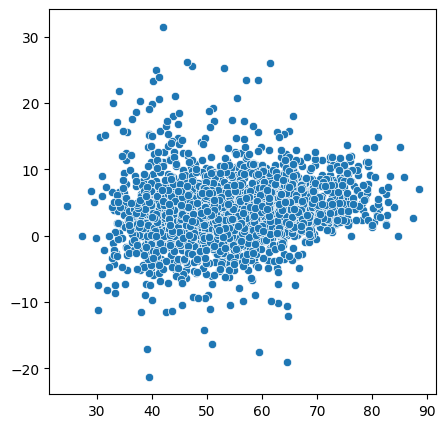

In [30]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x=[i.feature_vector[0] for i in counties_list], y=[i.feature_vector[1] for i in counties_list])
plt.show()

In [40]:
N_CLUSTERS = 10
model = KMeans(n_clusters=N_CLUSTERS)
#TODO czy kmeans może samo wybierać liczbę klastrów???
feature_vectors = np.array([c.feature_vector for c in counties_list])

results = model.fit_predict(feature_vectors)

c:\Users\piotr\Workspaces\USMigrations\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [56]:
import pickle 

with open('distributions.pickle', 'rb') as handle:
    distributions = pickle.load(handle)

In [58]:
for name, group in counties.groupby('State'):
    std = group.drop(['FIPS code', 'State', 'Area name'], axis=1).std()
    print(group.drop(['FIPS code', 'State', 'Area name'], axis=1).mean())
    for row in group.iterrows():
        print(row)
        break
    break

Higher Education                       48.908822
HPI                                     2.453125
Income                              76598.390625
Unemployment                            6.593750
Poor physical health days               4.895313
Poor mental health days                 4.762500
Violent crime                         343.496301
Severe housing problems                 0.151209
Income inequality                       5.129559
Access to exercise opportunities        0.477664
dtype: float64
(0, FIPS code                                    01001
State                                      Alabama
Area name                           Autauga County
Higher Education                          56.82587
HPI                                           2.64
Income                                       56954
Unemployment                                   5.1
Poor physical health days                      4.4
Poor mental health days                        4.3
Violent crime                   

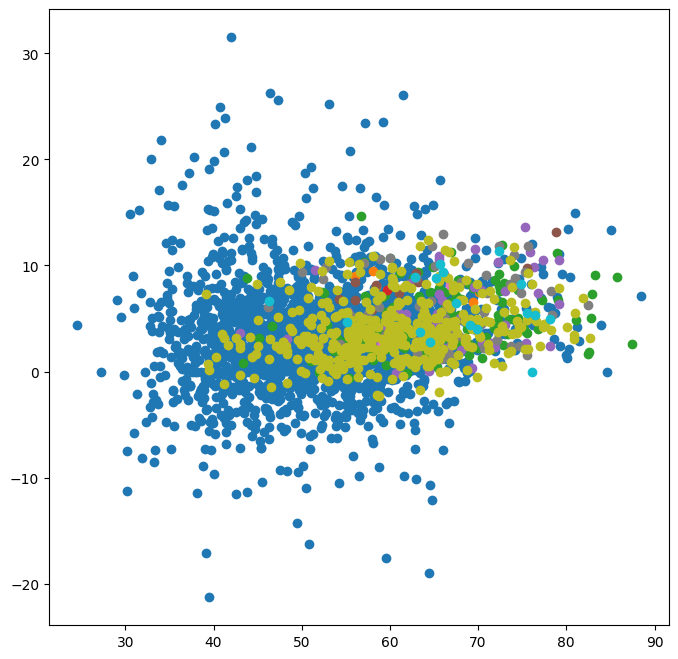

In [42]:
u_labels = np.unique(results)
pca = PCA(2)
df = pca.fit_transform(feature_vectors)
#plotting the results:
plt.figure(figsize=(8,8))
for i in u_labels:
    plt.scatter(feature_vectors[results == i , 0] , feature_vectors[results == i , 1] , label = i)
plt.show()

In [ ]:
Y_all = np.array([c.virtual_county for c in counties_list])
for n in range(N_CLUSTERS):
    X = feature_vectors[results == n]
    Y = Y_all[results == n]
    model = k.Sequential([k.layers.Dense(10, activation='relu', input_dim=5),
                          k.layers.Dense(10, activation='relu'),
                          k.layers.Dense(5, activation='relu')])
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    print(f'Model for cluster {n+1}')
    model.fit(X, Y, epochs=10, batch_size=10)
    for i, c in enumerate(counties_list):
        if n == results[i]:
            c._set_embeding_model(model)


### LOSOWANIE LUDZI

In [ ]:
N_LUDZI = 10
people_dict = {}
for county in counties_list:
    people_dict[county] = [Person(county) for _ in range(N_LUDZI)]

### Generowanie nurków

In [ ]:
import tqdm 
embeded_pople = []
for ks, v in tqdm.tqdm(people_dict.items()):
    tmp = np.empty((1, 5))
    for prs in v:
        tmp = np.vstack([tmp, prs.feature_vector])    
    predictions = ks.embed(tmp[1:, :])
    for idx, prs in enumerate(v):
        prs.embeded_vector = predictions[idx, :]
    embeded_pople.append(predictions)
embeded_pople = np.array(embeded_pople)
embeded_pople.shape

In [ ]:
embeded_pople = embeded_pople.reshape(-1, 5)

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=embeded_pople[:, 2], y=embeded_pople[:, 0])
plt.show()

In [ ]:
embeded_pople /= 5

### Decyzja czy ktoś migruje czy nie

In [ ]:
# people_dict[counties_list[0]][0].embeded_vector
for kc, v in people_dict.items():
    for ppl in v:
        ppl.distance_from_bith = np.linalg.norm(ppl.feature_vector - ppl.embeded_vector)

In [ ]:
# TODO tutaj trzeba podjebac kod od milcha
krowa = []
for kc, v in people_dict.items():
    for ppl in v:
        krowa.append(ppl.distance_from_bith)
plt.hist(krowa)
plt.show()

In [ ]:
from sklearn.neighbors import KDTree
from scipy.special import softmax


tree = KDTree(feature_vectors)

for kc, v in people_dict.items():
    for ppl in v:
        if ppl.distance_from_bith > 6:
            # get closest neighbors
            distances, idxs = tree.query(ppl.embeded_vector.reshape(1, -1), k = 10)
            ppl.migration_history.append(counties_list[np.random.choice(idxs.reshape(-1), p=softmax(distances).reshape(-1))])


In [ ]:
for kc, v in people_dict.items():
    for ppl in v:
        print(str(ppl.birthplace),str(ppl.migration_history))

In [12]:
embeded_pople = embeded_pople.reshape(-1, 5)

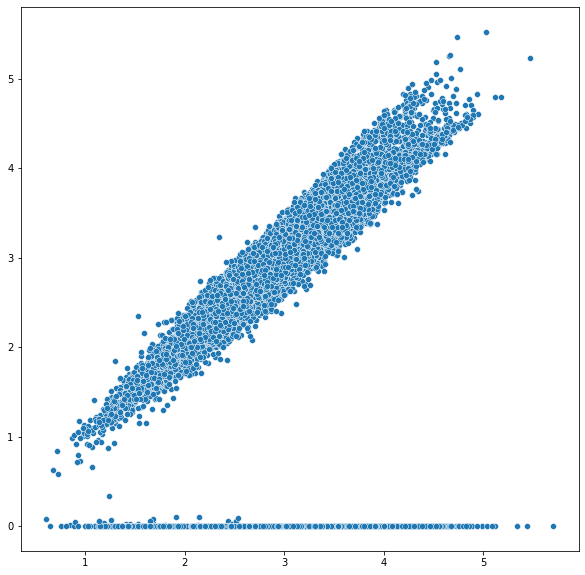

In [13]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=embeded_pople[:, 2], y=embeded_pople[:, 0])
plt.show()

In [14]:
embeded_pople /= 5

### Decyzja czy ktoś migruje czy nie

In [15]:
# people_dict[counties_list[0]][0].embeded_vector
for kc, v in people_dict.items():
    for ppl in v:
        ppl.distance_from_bith = np.linalg.norm(ppl.feature_vector - ppl.embeded_vector)

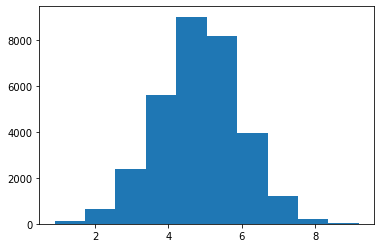

In [16]:
# TODO tutaj trzeba podjebac kod od milcha
krowa = []
for kc, v in people_dict.items():
    for ppl in v:
        krowa.append(ppl.distance_from_bith)
plt.hist(krowa)
plt.show()

In [48]:
from sklearn.neighbors import KDTree
from scipy.special import softmax


tree = KDTree(feature_vectors)

for kc, v in people_dict.items():
    for ppl in v:
        if ppl.distance_from_bith > 6:
            # get closest neighbors
            distances, idxs = tree.query(ppl.embeded_vector.reshape(1, -1), k = 10)
            ppl.migration_history.append(counties_list[np.random.choice(idxs.reshape(-1), p=softmax(distances).reshape(-1))])


In [50]:
for kc, v in people_dict.items():
    for ppl in v:
        print(str(ppl.birthplace),str(ppl.migration_history))

Autauga County, Alabama, 01001, [0.67739792 0.68081253 0.68536196 0.430393   0.42442472] []
Autauga County, Alabama, 01001, [0.67739792 0.68081253 0.68536196 0.430393   0.42442472] []
Autauga County, Alabama, 01001, [0.67739792 0.68081253 0.68536196 0.430393   0.42442472] []
Autauga County, Alabama, 01001, [0.67739792 0.68081253 0.68536196 0.430393   0.42442472] []
Autauga County, Alabama, 01001, [0.67739792 0.68081253 0.68536196 0.430393   0.42442472] []
Autauga County, Alabama, 01001, [0.67739792 0.68081253 0.68536196 0.430393   0.42442472] []
Autauga County, Alabama, 01001, [0.67739792 0.68081253 0.68536196 0.430393   0.42442472] []
Autauga County, Alabama, 01001, [0.67739792 0.68081253 0.68536196 0.430393   0.42442472] []
Autauga County, Alabama, 01001, [0.67739792 0.68081253 0.68536196 0.430393   0.42442472] []
Autauga County, Alabama, 01001, [0.67739792 0.68081253 0.68536196 0.430393   0.42442472] []
Baldwin County, Alabama, 01003, [0.88326366 0.64982672 0.23355929 0.87175146 0.3